In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.utils.data as data
from tqdm.auto import tqdm
from models import lenet5Conv
from models import lenet5Deconv
import prepare_data

In [2]:
# training data
train_img_filepath = 'DATA/MNSIT/train-images.idx3-ubyte'
train_label_filepath = 'DATA/MNSIT/train-labels.idx1-ubyte'

# testing data
test_img_filepath = 'DATA/MNSIT/t10k-images.idx3-ubyte'
test_label_filepath = 'DATA/MNSIT/t10k-labels.idx1-ubyte'


In [3]:
# batch size of 64
BATCH_SIZE = 64

train_loader, test_loader = prepare_data.load(train_img_filepath, 
                                            train_label_filepath, 
                                            test_img_filepath,
                                            test_label_filepath, 
                                            BATCH_SIZE
                                        )
        

In [4]:
# setting the device on which PyTorch trains to CPU; Can set it to GPU is GPU is available
device = 'cpu'

In [5]:
# Defining accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc
    
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        
        # Send training data to CPU or GPU
        X = X.to(torch.float32)
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # logits to prediction label

        # Grad of optimizer to zero (optimization the weights)
        optimizer.zero_grad()

        # Update the weights by backpropagation
        loss.backward()
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss.detach().to('cpu').numpy(), train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in evaluation mode

    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send testing data to CPU or GPU
            X = X.to(torch.float32)
            X, y = X.to(device), y.to(device)
            # X = torch.unsqueeze(X,0)
            # Forward pass
            test_pred = model(X)
            
            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # logits to prediction label
            )
        
    
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss.detach().to('cpu').numpy(), test_acc


In [6]:
torch.manual_seed(42)
model = lenet5Conv(1, [6, 16], 10)
model.to(device)
model

lenet5Conv(
  (first_conv2d): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (first_ReLU): ReLU()
  (first_maxPool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (second_conv2d): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (second_ReLU): ReLU()
  (second_maxPool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
    (6): LogSoftmax(dim=1)
  )
)

## Loading trained model weights

In [7]:
# model.load_state_dict(torch.load('models/saved/lenet5.pth'))

Skip training if loading the saved weights

In [8]:
# Cross entropy loss
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.NLLLoss()

# Adam optimizer with learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
EPOCHS = 20

train_plot = []
test_plot = []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_loader, 
        model=model, 
        loss_fn=loss_function,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    
    train_plot.append((train_acc, train_loss))

    test_loss, test_acc = test_step(data_loader=test_loader,
        model=model,
        loss_fn=loss_function,
        accuracy_fn=accuracy_fn
    )
    test_plot.append((test_acc, test_loss))
    

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.27863 | Train accuracy: 91.51%
Test loss: 0.08052 | Test accuracy: 97.41%

Epoch: 1
---------
Train loss: 0.07733 | Train accuracy: 97.57%
Test loss: 0.05508 | Test accuracy: 98.29%

Epoch: 2
---------
Train loss: 0.05624 | Train accuracy: 98.26%
Test loss: 0.04020 | Test accuracy: 98.66%

Epoch: 3
---------
Train loss: 0.04354 | Train accuracy: 98.63%
Test loss: 0.03687 | Test accuracy: 98.68%

Epoch: 4
---------
Train loss: 0.03485 | Train accuracy: 98.90%
Test loss: 0.03205 | Test accuracy: 98.93%

Epoch: 5
---------
Train loss: 0.02867 | Train accuracy: 99.05%
Test loss: 0.03838 | Test accuracy: 98.79%

Epoch: 6
---------
Train loss: 0.02463 | Train accuracy: 99.25%
Test loss: 0.03487 | Test accuracy: 98.80%

Epoch: 7
---------
Train loss: 0.02103 | Train accuracy: 99.31%
Test loss: 0.03821 | Test accuracy: 98.87%

Epoch: 8
---------
Train loss: 0.01749 | Train accuracy: 99.44%
Test loss: 0.03896 | Test accuracy: 98.86%

Epoch: 9
---------
Train los

Text(0, 0.5, 'Accuracy %')

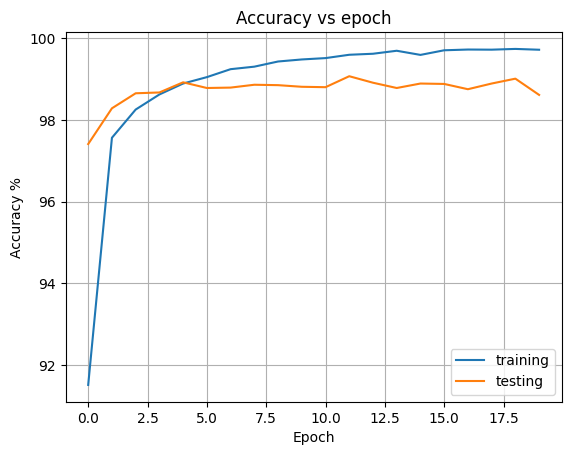

In [10]:
plt.plot([i[0] for i in train_plot], label='training')
plt.plot([i[0] for i in test_plot], label='testing')
plt.grid()
plt.legend()
plt.title('Accuracy vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')

Text(0, 0.5, 'Loss')

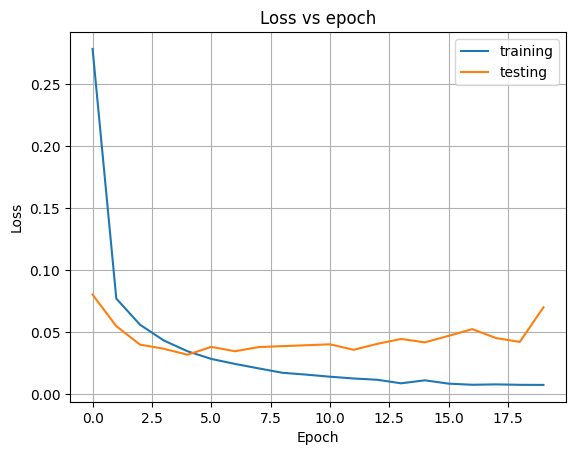

In [11]:
plt.plot([i[1] for i in train_plot], label='training')
plt.plot([i[1] for i in test_plot], label='testing')
plt.grid()
plt.legend()
plt.title('Loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Save the model

In [12]:
torch.save(model.state_dict(), 'models/saved/lenet5.pth')

Feature Extracter class which saves the outputs of the model when an input is passed through it

In [13]:
class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        self._features = dict() # save the outputs into to dict with the help of PyTorch hooks

        layers = dict([*self.model.named_modules()])
        for layer_id, layer in layers.items():
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str):
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x):
        self.model.eval() # eval mode to prevent training
        _ = self.model(x)
        return self._features

In [14]:
# Trained weights for our model
conv_model_weights = dict(model.named_parameters())

In [15]:
test_batch_features, test_batch_lables = next(iter(test_loader))

In [16]:
# Pick a test input from the loader
# No. -> IDX
# 0 - 10
# 1 - 2
# 5 - 15
# 8 - 61
test_idx = 15 
test_input = test_batch_features[test_idx]
test_input = torch.unsqueeze(test_input,0)
test_input = test_input.to(torch.float32)

Test input prediction

In [17]:
model.eval()
test_input_pred = model(test_input)
prediction = test_input_pred.argmax(1)[0]
print(f"The actual label: {test_batch_lables[test_idx]} & Predicted label: {prediction}")

The actual label: 5 & Predicted label: 5


In [18]:
# Create the feature extractor and pass the test input
model_features = FeatureExtractor(model)
features = model_features(test_input)

In [19]:
# With the features extracted, initialize the deconv model
model_deconv = lenet5Deconv([6, 16],conv_model_weights)
model_deconv.eval()

# Switches for the MaxPooling layers
switch = {'first_maxPool2d': features['first_maxPool2d'][1], 'second_maxPool2d':features['second_maxPool2d'][1] }

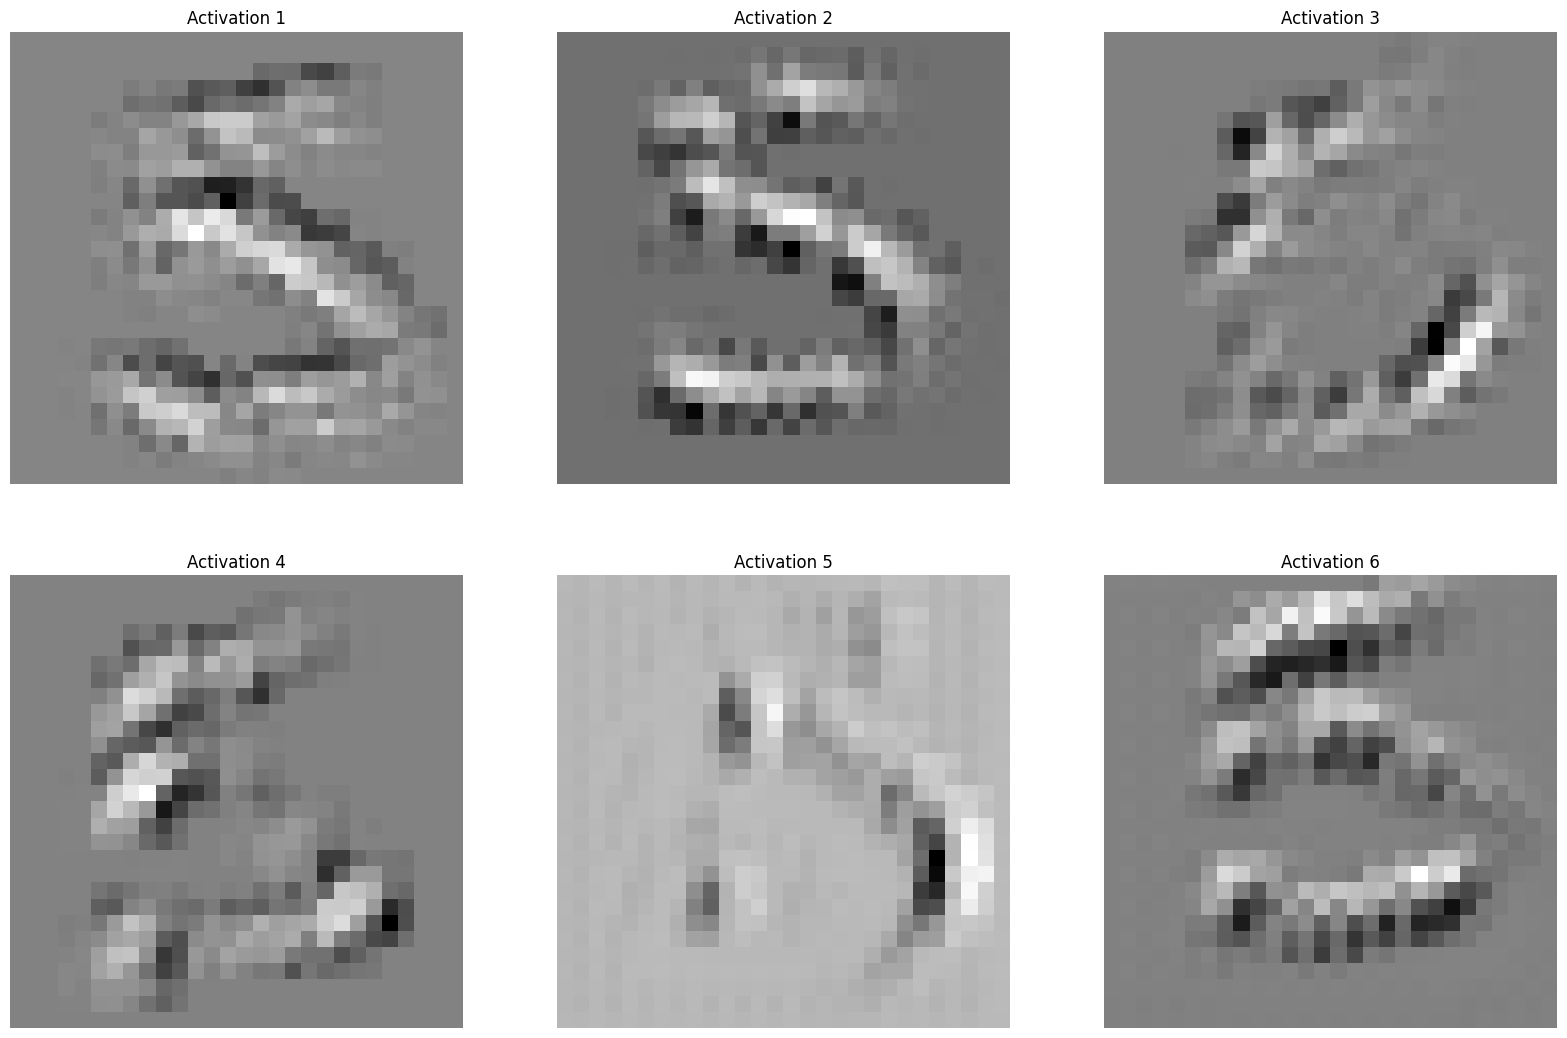

In [20]:
# layer = 'second_maxPool2d' # to vizualize from the second layer
layer = 'first_maxPool2d' # to vizualize from the first layer
num_feat = features[layer][0].shape[1] # get the number of features in that layer
feat_map = features[layer][0].clone() # clone the output of layer for further modification

plt.figure(figsize=(20,20))

for i in range(0, num_feat):
    # Choose 'i'th feature/activation map and proceed with vizualization
    choose_map = feat_map[0, i, :, :]
    
    # Zeroing other feature maps
    new_feat_map = torch.zeros(feat_map.shape)
    new_feat_map[0, i, :, :] = choose_map 

    # Passing the map to the decovn model
    new_img = model_deconv(new_feat_map, layer, switch)
    
    # Reshaping the image for plotting
    new_img = torch.squeeze(new_img, 1)
    new_img = torch.squeeze(new_img, 0)
    
    new_img = new_img.data.numpy()
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min()) * 255
    new_img = new_img.astype(np.uint8)
    
    plt.subplot(num_feat//2, num_feat //2, i+1)
    plt.imshow(new_img, cmap='gray')
    plt.title(f"Activation {i+1}")
    plt.axis(False)
